### Import Library

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import lightgbm as lgb
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import seaborn as sns
import matplotlib.pyplot as plt


### Load Data

In [2]:
path = "../data/"

train = pd.read_csv(path+"train.csv").assign(_type="train")
test = pd.read_csv(path+"test.csv").assign(_type="test")
submission = pd.read_csv(path+"test.csv")
df = pd.concat([train, test], axis=0)

In [3]:
prefixes = ["HOURLY_NETWORK-DATA_",
            "HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD",
            "HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX",
            "HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE",
            "HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL",
            "HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL",
            "HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_ALL_EXCHANGE"]

file_names = [
    f for f in os.listdir(path)
    if any(f.startswith(prefix) for prefix in prefixes) and f.endswith(".csv")
]
display(file_names)
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(path+f) for f in file_names
}


for _file_name, _df in tqdm(file_dict.items()):
    _rename_rule = {
        col: f"{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


['HOURLY_NETWORK-DATA_TRANSACTIONS-COUNT.csv',
 'HOURLY_MARKET-DATA_TAKER-BUY-SELL-STATS_ALL_EXCHANGE.csv',
 'HOURLY_NETWORK-DATA_BLOCK-INTERVAL.csv',
 'HOURLY_NETWORK-DATA_ADDRESSES-COUNT.csv',
 'HOURLY_MARKET-DATA_COINBASE-PREMIUM-INDEX.csv',
 'HOURLY_MARKET-DATA_OPEN-INTEREST_ALL_EXCHANGE_ALL_SYMBOL.csv',
 'HOURLY_NETWORK-DATA_HASHRATE.csv',
 'HOURLY_NETWORK-DATA_BLOCKREWARD.csv',
 'HOURLY_NETWORK-DATA_SUPPLY.csv',
 'HOURLY_MARKET-DATA_FUNDING-RATES_ALL_EXCHANGE.csv',
 'HOURLY_MARKET-DATA_PRICE-OHLCV_ALL_EXCHANGE_SPOT_BTC_USD.csv',
 'HOURLY_NETWORK-DATA_BLOCK-COUNT.csv',
 'HOURLY_NETWORK-DATA_UTXO-COUNT.csv',
 'HOURLY_NETWORK-DATA_BLOCK-BYTES.csv',
 'HOURLY_NETWORK-DATA_FEES-TRANSACTION.csv',
 'HOURLY_NETWORK-DATA_TOKENS-TRANSFERRED.csv',
 'HOURLY_NETWORK-DATA_FEES.csv',
 'HOURLY_NETWORK-DATA_VELOCITY.csv',
 'HOURLY_NETWORK-DATA_DIFFICULTY.csv',
 'HOURLY_MARKET-DATA_LIQUIDATIONS_ALL_EXCHANGE_ALL_SYMBOL.csv']

100%|██████████| 20/20 [00:00<00:00, 31.67it/s]


In [4]:
# 전체 독립변수에서 내가 사용할 독립변수 고르기
features = ['ID', 'target', '_type', 'funding_rates', 'open_interest',
       'taker_buy_volume', 'taker_sell_volume', 'taker_buy_ratio',
       'taker_sell_ratio', 'taker_buy_sell_ratio', 'difficulty',
       'transactions_count_total', 'transactions_count_mean', 'block_count',
       'fees_transaction_mean', 'fees_transaction_mean_usd',
       'fees_transaction_median', 'fees_transaction_median_usd',
       'fees_block_mean', 'fees_block_mean_usd', 'fees_total',
       'fees_total_usd', 'fees_reward_percent', 'hashrate', 'utxo_count',
       'tokens_transferred_total', 'tokens_transferred_mean',
       'tokens_transferred_median', 'block_interval', 'velocity_supply_total',
       'supply_total', 'supply_new', 'addresses_count_active',
       'addresses_count_sender', 'addresses_count_receiver',
       'blockreward', 'blockreward_usd', 'liquidation_diff',
       'liquidation_usd_diff', 'volume_diff', 'liquidation_diffg',
       'liquidation_usd_diffg', 'volume_diffg', 'buy_sell_volume_ratio']
fe = ['ID', 'target', '_type', 'funding_rates', 
      'long_liquidations','short_liquidations', 'long_liquidations_usd', 'short_liquidations_usd',
       'open_interest', 'taker_buy_volume', 'taker_sell_volume', 'taker_buy_ratio',
       'taker_sell_ratio', 'taker_buy_sell_ratio', 'difficulty',
       'transactions_count_total', 'transactions_count_mean', 'block_count',
       'fees_transaction_mean', 'fees_transaction_mean_usd',
       'fees_transaction_median', 'fees_transaction_median_usd',
       'fees_block_mean', 'fees_block_mean_usd', 'fees_total',
       'fees_total_usd', 'fees_reward_percent', 'hashrate', 'utxo_count',
       'tokens_transferred_total', 'tokens_transferred_mean',
       'tokens_transferred_median', 'block_interval', 'velocity_supply_total',
       'supply_total', 'supply_new', 'addresses_count_active',
       'addresses_count_sender', 'addresses_count_receiver', 'block_bytes',
       'blockreward', 'blockreward_usd']

new_features = [x for x in fe if x not in features]

In [5]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["taker_buy_volume"] - df["taker_sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["taker_buy_volume"] - df["taker_sell_volume"]),
    buy_sell_volume_ratio=df["taker_buy_volume"] / (df["taker_sell_volume"] + 1),
)
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in (df.columns)[3:] if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
]

In [6]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [7]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)
df = df.loc[:, ~df.columns.duplicated()]
df = df.drop(columns=new_features)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

### Model Training

In [8]:
# def add_jitter(df, jitter_strength=0.01):
#     """
#     Adds random jitter to each numeric column in the DataFrame, excluding object (string) columns.

#     Parameters:
#     - df (pd.DataFrame): The original DataFrame.
#     - jitter_strength (float): The strength of the jitter. Higher values add more noise.

#     Returns:
#     - pd.DataFrame: The DataFrame with added jitter.
#     """
#     # 숫자형 데이터만 선택
#     numeric_df = df.select_dtypes(include=[np.number])

#     # 지터 추가
#     jitter = np.random.normal(loc=0, scale=jitter_strength, size=numeric_df.shape)
#     numeric_df_jittered = numeric_df + jitter

#     # 원본 데이터프레임에 지터가 추가된 숫자형 데이터로 업데이트
#     df_jittered = df.copy()
#     df_jittered[numeric_df.columns] = numeric_df_jittered

#     return df_jittered

# # 지터 추가
# df_jittered = add_jitter(train_df, jitter_strength=0.05)

# print(df.head())
# print(df_jittered.head())

In [9]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1),
    train_df["target"].astype(int),
    test_size=0.2,
    random_state=42,
)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


# 랜덤 포레스트 모델 학습
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=2, random_state=42)
rf_model.fit(x_train, y_train)

# lgb predict
y_valid_pred = rf_model.predict_proba(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

acc: 0.4389269406392694, auroc: 0.6432039099932516


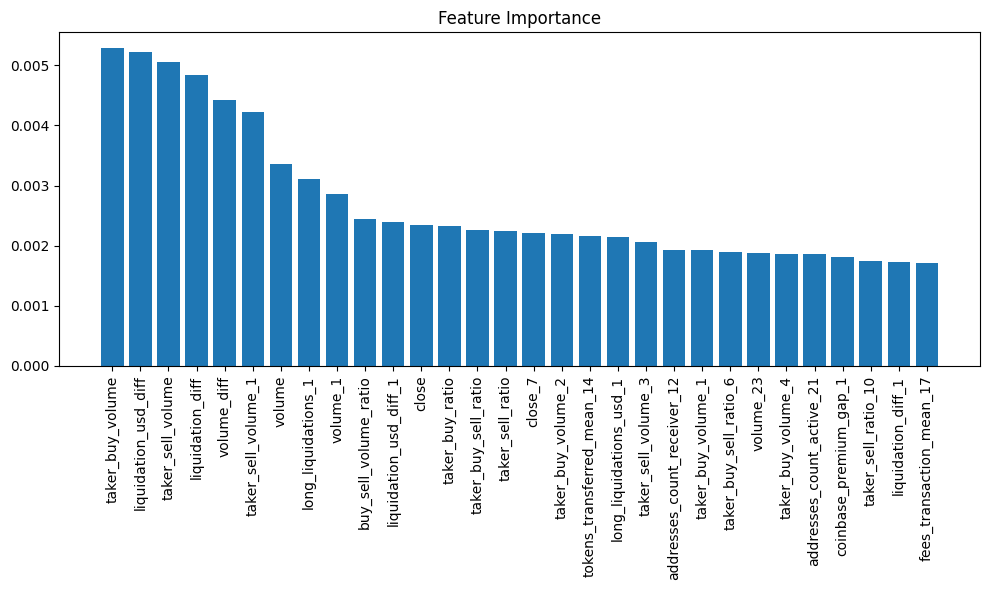

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Feature Importance 계산
importances = rf_model.feature_importances_

# Feature Importance를 시각화
features = x_train.columns  # 피처 이름 가져오기
indices = np.argsort(importances)[::-1]  # 중요도가 높은 순으로 정렬

top_n = 30
indices = indices[:top_n]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(top_n), importances[indices], align="center")
plt.xticks(range(top_n), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [10]:
# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df.drop(["target", "ID"], axis = 1)
y_train = train_df["target"].astype(int)

rf_model_all = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=2, random_state=42)
rf_model_all.fit(x_train, y_train)

KeyboardInterrupt: 

In [16]:
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 하이퍼파라미터 튜닝 예시
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 30, 50],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(x_train, y_train)

# 최적의 파라미터 출력
print(grid_search.best_params_)


{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}


### Inference

In [20]:
y_test_pred = rf_model_all.predict_proba(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

### Output File Save

In [21]:
submission = submission.assign(target = y_test_pred_class)
submission.to_csv("output6.csv", index=False)